# Sequence model  on KaggleCompetition data set 

The first model would be only for the title column with a binary target Fake/Not Fake.
This model is done by Andrii Shchur, 2020
Here is its [article](https://towardsdatascience.com/fake-news-detector-with-deep-learning-approach-part-i-eda-757f5c052)

Complete dataset cannot be distributed because of Twitter privacy policies and news publisher copy rights. Social engagements and user information are not disclosed because of Twitter Policy.  

The minimalistic version of latest dataset provided in this repo (located in dataset folder) include following files:

- politifact_fake.csv - Samples related to fake news collected from PolitiFact
- politifact_real.csv - Samples related to real news collected from PolitiFact

Each of the above CSV files is comma separated file and have the following columns

- id - Unique identifider for each news
- url - Url of the article from web that published that news
- title - Title of the news article
- tweet_ids - Tweet ids of tweets sharing the news. This field is list of tweet ids separated by tab.

<img src='https://media.giphy.com/media/l0Iyau7QcKtKUYIda/giphy.gif'>

### <span style="background-color: #FFFF00">In this notebook, I have corrected the preprocessing of the data</span>

## Importing packages 

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import os.path as op
import time
import matplotlib.pyplot as plt
#Loading tensorflow and keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from keras.utils import plot_model
#Loading nltk
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#Loading sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
#Loading K-folds
from sklearn.model_selection import StratifiedKFold
#Loading the model
import sys  
sys.path.insert(0, '../../models')
from PY.model5 import get_model

Using TensorFlow backend.


## Paths 

In [2]:
DATA_DIR = '../../../../Data'
CODE_DIR_H5='../../models/H5'
# Create a path for the saving location of the model
MODEL_DIR_H5 = CODE_DIR_H5 + '/model5_Politifact.h5'

## Loading Data 

In [3]:
# Load train data
train = pd.read_csv(op.join(DATA_DIR, 'politifact/Claims_to_work_with/claims.csv'))
train

author  label  \
0                                            Paul LePage      1   
1                                     Battleground Texas      0   
2                                     Battleground Texas      0   
3                                         Suzanne Somers      0   
4                                           Jamie Oliver      0   
...                                                  ...    ...   
10459                                       Bill O'Neill      1   
10460                                       Presente.org      0   
10461                                       Presente.org      1   
10462  Local 799 of the International Assoc. of Fire ...      1   
10463                                     Jason Chaffetz      1   

                                                   title  
0      About 47 percent of able-bodied people in the ...  
1      Says Dan Patrick has "called immigration into ...  
2      In 2008, "only 54 percent of Latinos in Texas ...  
3      Even after Obamacare is fully implemented, the...  
4      McDonald's in England only sells organic milk ...  
...                                                  ...  
10459  In recent years, Rep. LaTourette has sponsored...  
10460  91 percent of Latinos support the DREAM Act, w...  
10461  Rep. Adam Putnam was silent when Rush Limbaugh...  
10462  Elorza wants to teach our public school childr...  
10463  We had people that were getting killed (in Ben...  

[10464 rows x 3 columns]

In [29]:
# Find Na 
train.isnull().sum()

id           0
title        0
author    1957
text         0
label        0
dtype: int64

In [30]:
#Get the Depndent feature
X_train=train.drop('label',axis=1)
y_train=train['label']

In [31]:
# set vocabulary size
vo_size=500
messages=X_train.copy()
messages.reset_index(inplace=True)

In [32]:
len(messages), len(y_train)

(20800, 20800)

In [33]:
# Dataset Preprocessing
cmp=0
ps =PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    print("Status: %s / %s" %(i, len(messages)), end="\r")
    review = re.sub('[^a-zA-Z]', ' ',messages['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    if review :
        review = ' '.join(review)
        corpus.append(review)
        y_train[i]=y_train[i]
    else :
        cmp=cmp+1
        y_train[i]=np.nan
y_train.reset_index()

Status: 13 / 20800

C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\CBS Compter\anaconda3\envs\tensorflow7\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


index  label
0          0    1.0
1          1    0.0
2          2    1.0
3          3    1.0
4          4    1.0
...      ...    ...
20795  20795    0.0
20796  20796    0.0
20797  20797    0.0
20798  20798    1.0
20799  20799    1.0

[20800 rows x 2 columns]

In [34]:
print('the number of lines that could not be preprocessed',cmp)

the number of lines that could not be preprocessed 163


In [35]:
print("We need to delete those",y_train.isnull().sum(),"lines from the label column")
y_train=y_train.dropna()
y_train.astype('Int64')

We need to delete those 163 lines from the label column


0        1
1        0
2        1
3        1
4        1
        ..
20795    0
20796    0
20797    0
20798    1
20799    1
Name: label, Length: 20637, dtype: Int64

In [36]:
# one hot representation
onehot_rep = [one_hot(words, vo_size) for words in corpus]

In [37]:
# pad_sequences
sent_length = 108
embedded_doc=pad_sequences(onehot_rep, padding='pre', maxlen=sent_length)
print(embedded_doc)

[[  0   0   0 ... 359 128 412]
 [  0   0   0 ...  81  22 450]
 [  0   0   0 ...  89 181  49]
 ...
 [  0   0   0 ... 279 450 372]
 [  0   0   0 ... 110  34 375]
 [  0   0   0 ... 487 480 306]]


In [38]:
embedding_vector_feature = 10

In [39]:
# check shape 
len(embedded_doc),y_train.shape

(20637, (20637,))

In [40]:
# final data for NN
X_final=np.array(embedded_doc)
y_final=np.array(y_train)
X_final.shape,y_final.shape

((20637, 20), (20637,))

## Training  the model 

In [17]:
start=time.time()
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores1 = []
cvscores2 = []
cvscores3 = []
cvscores4 = []
num_iter=0
for train, test in kfold.split(X_final, y_final):
    num_iter=num_iter+1
    model=get_model(vo_size,embedding_vector_feature,sent_length)
    # Fit the model
    history=model.fit(X_final[train], y_final[train], epochs=10, batch_size=64,verbose=0)
    # evaluate the model
    scores = model.evaluate(X_final[test], y_final[test], verbose=0)
    print("------subset number", num_iter,"------")
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores1.append(scores[1] * 100)
    print("%s: %.2f%%" % (model.metrics_names[2], scores[2]*100))
    cvscores2.append(scores[2] * 100)
    print("%s: %.2f%%" % (model.metrics_names[3], scores[3]*100))
    cvscores3.append(scores[3] * 100)
    print("%s: %.2f%%" % (model.metrics_names[4], scores[4]*100))
    cvscores4.append(scores[4] * 100)
print("--------------------------------------------" )   
print("accuracy","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores1), np.std(cvscores1)))
print("precision","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores2), np.std(cvscores2)))
print("recall","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores3), np.std(cvscores3)))
print("f1-mesure","%.2f%% (+/- %.2f%%)" % (np.mean(cvscores4), np.std(cvscores4)))
end=time.time()

------subset number 1 ------
accuracy: 90.21%
precision_mesure: 49.71%
recall_mesure: 100.00%
f1_mesure: 65.78%
------subset number 2 ------
accuracy: 91.91%
precision_mesure: 49.66%
recall_mesure: 100.00%
f1_mesure: 66.04%
------subset number 3 ------
accuracy: 91.42%
precision_mesure: 49.76%
recall_mesure: 100.00%
f1_mesure: 66.05%
------subset number 4 ------
accuracy: 91.52%
precision_mesure: 49.57%
recall_mesure: 100.00%
f1_mesure: 65.74%
------subset number 5 ------
accuracy: 92.54%
precision_mesure: 49.66%
recall_mesure: 100.00%
f1_mesure: 66.03%
------subset number 6 ------
accuracy: 91.62%
precision_mesure: 49.81%
recall_mesure: 100.00%
f1_mesure: 65.88%
------subset number 7 ------
accuracy: 90.41%
precision_mesure: 49.62%
recall_mesure: 100.00%
f1_mesure: 65.82%
------subset number 8 ------
accuracy: 90.64%
precision_mesure: 49.82%
recall_mesure: 100.00%
f1_mesure: 65.94%
------subset number 9 ------
accuracy: 91.61%
precision_mesure: 49.66%
recall_mesure: 100.00%
f1_mesure:

In [18]:
# Save the model
model.save(MODEL_DIR_H5)
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 20, 10)            5000      
_________________________________________________________________
lstm_9 (LSTM)                (None, 20, 100)           44400     
_________________________________________________________________
flatten_9 (Flatten)          (None, 2000)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 4002      
Total params: 53,402
Trainable params: 53,402
Non-trainable params: 0
_________________________________________________________________


In [19]:
print('time of training' , end-start)

time of training 1083.893452167511


## Evaluation metrics

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

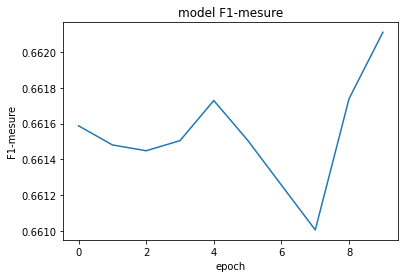

In [22]:
# summarize history for f1-mesure
plt.plot(history.history['f1_mesure'])
plt.title('model F1-mesure')
plt.ylabel('F1-mesure')
plt.xlabel('epoch')
plt.show()

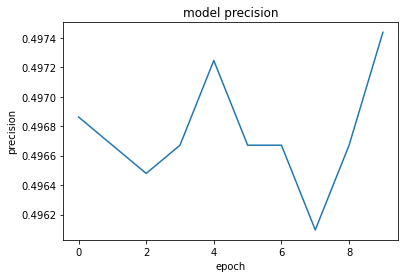

In [23]:
# summarize history for precision
plt.plot(history.history['precision_mesure'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.show()

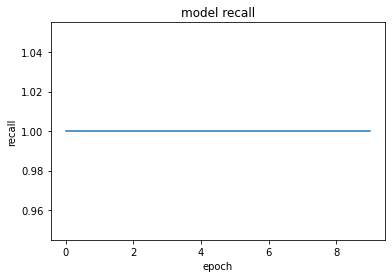

In [24]:
# summarize history for recall
plt.plot(history.history['recall_mesure'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.show()